In [1]:
# !pip install wandb

In [2]:
import numpy as np 
import pandas as pd 
import os
import wandb
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss , AvgPool2d, Linear
import torchvision.utils as vutils

%matplotlib inline

In [3]:
print("DATASET LOADED")

DATASET LOADED


In [4]:
!wandb login 08836028c4159212c320516a4f9103655dbf9ae6

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.init(project="PEG", entity="bhuvanesh_ai")

wandb: Currently logged in as: bhuvanesh_ai. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240307_135144-6u3xgdc0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run avid-darkness-17
wandb: ⭐️ View project at https://wandb.ai/bhuvanesh_ai/PEG
wandb: 🚀 View run at https://wandb.ai/bhuvanesh_ai/PEG/runs/6u3xgdc0


In [6]:
dir_data = "/kaggle/input/procedural-environment-generation/dataset/dataset"
img_shape = (256,256,1)
img_paths = [dir_data + '/' + file for file in os.listdir(dir_data)]
img_paths = img_paths[:-6]

In [7]:
img_paths = np.sort(img_paths)

In [8]:
def load_images(img_paths):
    for image in img_paths:
        img = Image.open(image)
        img_array = np.array(img)
        img_array_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
        
        yield np.transpose(np.expand_dims(np.float32(img_array_normalized), axis = 2),(2,0,1))

In [9]:
def plot_images(imgs, grid_size = 5):

    fig = plt.figure(figsize = (6,6))
    plt.axis("off")
    columns = rows = grid_size
    plt.title("Training Images")
    images = load_images(imgs)
    for i in range(1, columns*rows +1):
        
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.imshow(np.transpose(next(images), (1,2,0)), cmap = 'gray')
        
    plt.show()

In [10]:
images = load_images(img_paths)
image = next(images)

In [11]:
image.size

65536

In [12]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

In [13]:
device

device(type='cuda', index=0)

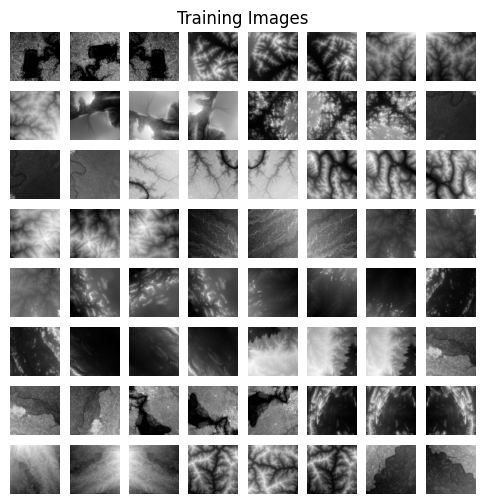

In [14]:
plot_images(img_paths, 8)

In [15]:
class Terrains(Dataset):
    def __init__(self, img_paths):
        '''np array containing all paths to all images'''
        self.img_paths = img_paths
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = next(load_images([self.img_paths[idx]]))
        return image

In [16]:
dset = Terrains(img_paths)
batch_size = 128
shuffle = True

In [17]:
dataloader = DataLoader(dataset = dset, batch_size = batch_size, shuffle = shuffle, num_workers = 2)

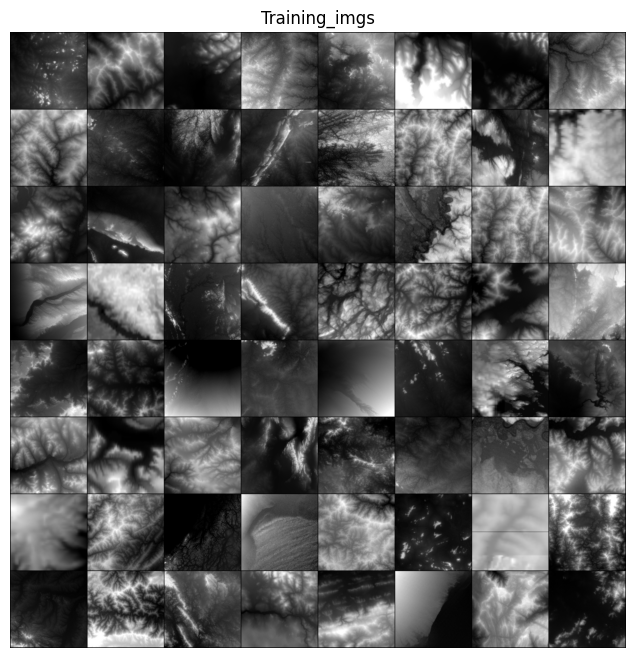

In [18]:
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training_imgs")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding = 2, normalize=True).cpu(),(1,2,0)), cmap='gray')
plt.show()

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [20]:
D_lr = 0.00005
G_lr = 0.00005
FILTER_SIZE = 8
BATCH_SIZE = 128

In [21]:
s = 256
s2, s4, s8 = int(s/2), int(s/4), int(s/8)
g_dim = 64
c_dim = 1

In [22]:
# class Generator(Module):
    
    
#     def __init__(self, batch_size, reuse = False):
#         super().__init__()
               
#         output2_shape = [batch_size, g_dim, s4 , s4 ]
#         self.b_conv2 = nn.Parameter(torch.ones(output2_shape[1]) * 0.1)
#         self.resize_layer2 = nn.Upsample(size=(output2_shape[2], output2_shape[3]), mode='nearest')
#         self.conv2 = nn.Conv2d(in_channels=g_dim, out_channels=s4, kernel_size=(FILTER_SIZE, FILTER_SIZE), padding='same')
#         self.batch_norm2 = nn.BatchNorm2d(s4)
        
#         output3_shape = [batch_size,g_dim*2, s2 , s2 ]
#         self.b_conv3 = nn.Parameter(torch.ones(output3_shape[1]) * 0.1)
#         self.resize_layer3 = nn.Upsample(size=(output3_shape[2], output3_shape[3]), mode='nearest')
#         self.conv3 = nn.Conv2d(in_channels=g_dim, out_channels=s8, kernel_size=(FILTER_SIZE, FILTER_SIZE), padding='same')
#         self.batch_norm3 = nn.BatchNorm2d(s8)
        
#         output4_shape = [batch_size, c_dim, s, s]
#         self.b_conv4 = nn.Parameter(torch.ones(output4_shape[1]) * 0.1)
#         self.resize_layer4 = nn.Upsample(size=(output4_shape[2], output4_shape[3]), mode='nearest')
#         self.conv4 = nn.Conv2d(in_channels=s8, out_channels=1, kernel_size=(FILTER_SIZE, FILTER_SIZE), padding='same')
        
#     def forward(self, z):
#         batch_temp = z.shape[0]
#         h0 = torch.reshape(z, [batch_temp, 64,s8,s8])
#         h0 = LeakyReLU()(h0)
# #         print(h0.shape)
#         h_conv2 = self.resize_layer2(h0) + self.b_conv2
# #         print(h_conv2.shape)
#         h_conv2 = self.conv2(h_conv2)
# #         print(h_conv2.shape)
#         h_conv2 = LeakyReLU()(h_conv2)
#         h_conv2 = self.batch_norm2(h_conv2)
#         h_conv2 = LeakyReLU()(h_conv2)
        
#         h_conv3 = self.resize_layer3(h_conv2) + self.b_conv3
# #         print(h_conv3.shape)
#         h_conv3 = self.conv3(h_conv3)
# #         print(h_conv3.shape)
#         h_conv3 = LeakyReLU()(h_conv3)
#         h_conv3 = self.batch_norm3(h_conv3)
#         h_conv3 = LeakyReLU()(h_conv3)
        
#         h_conv4 = self.resize_layer4(h_conv3) + self.b_conv4
# #         print(h_conv4.shape)
#         h_conv4 = self.conv4(h_conv4)
# #         print(h_conv4.shape)
#         h_conv4 = LeakyReLU()(h_conv4)
#         h_conv4 = Tanh()(h_conv4)
        
#         return h_conv4

In [23]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is a random noise vector of size nz
            # Output: (ngf * 16) x 4 x 4 (initial layer is doubled for larger image)
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            # Output: (ngf * 8) x 8 x 8
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Output: (ngf * 4) x 16 x 16
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Output: (ngf * 2) x 32 x 32
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Output: (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Output: (nc) x 256 x 256
            nn.ConvTranspose2d(ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [24]:
# class Discriminator(Module):
#     def __init__(self):
#         super().__init__()
#         self.leaky_relu = LeakyReLU()
#         #256x256x1
#         self.conv1 = Conv2d(in_channels=1, out_channels= 8 , kernel_size = 5, stride = 1, padding=1, bias = False)
#         #leaky relu here
#         #256x256x8
#         self.pool1 = AvgPool2d(kernel_size=2, stride = 2, padding = 1)
#         #128x128x8
#         self.conv2 = Conv2d(in_channels=8, out_channels= 16 , kernel_size = 5, stride = 1, padding=1,  bias = False)
# #         LeakyRelu here
#         #128x128x16
#         self.pool2 = AvgPool2d(kernel_size=2, stride = 2, padding = 1)
#         #64x64x16
#         #add flatten
#         self.dimval = 64*64*16
        
#         self.fc1 = Linear(self.dimval, 32,  bias = False)
# #         LeakyReLU here
#         self.fc2 = Linear(32, 1,  bias = False)
# #         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, inputs):
# #         print(inputs.shape)
#         x = self.conv1(inputs)
# #         print(x.shape)
#         x = self.leaky_relu(x)
# #         print(x.shape)
#         x = self.pool1(x)
# #         print(x.shape)
#         x = self.conv2(x)
# #         print(x.shape)
#         x = self.leaky_relu(x)
# #         print(x.shape)
#         x = self.pool2(x)
# #         print(x.shape)
        
#         x = torch.reshape(x, [x.shape[0], self.dimval])
        
#         x = self.fc1(x)
#         x = self.leaky_relu(x)
        
#         x =  self.fc2(x)
# #         output = self.sigmoid(x)
#         return x

In [25]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 4, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [26]:
ngpu = 2
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [27]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), strid

In [28]:
netD = Discriminator(ngpu).to(device)
# # Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (12): Sigmoid(

In [29]:
def filtered_params(model):
    return [param for name, param in model.named_parameters() if 'batch' not in name]
params = filtered_params(netG)

In [30]:
fixed_noise = torch.randn(batch_size, 100, 1,1,device = device)

In [31]:
real_label = 1
fake_label = 0

In [32]:
workers = 2
num_epochs = 5
beta1 = 0.5

In [33]:
optimizerD = optim.RMSprop(netD.parameters(), lr = D_lr)
optimizerG = optim.RMSprop(netG.parameters(), lr = G_lr)

In [34]:
device

device(type='cuda', index=0)

In [35]:
!mkdir checkpoints

Starting Training Loop...
[1/5][0/660]	Loss_D: -0.0026	Loss_G: -0.4988	D(x): 0.5016	D(G(z)): 0.4990 / 0.4988
[1/5][50/660]	Loss_D: -0.0413	Loss_G: -0.4875	D(x): 0.5214	D(G(z)): 0.4800 / 0.4875
[1/5][100/660]	Loss_D: -0.0979	Loss_G: -0.4766	D(x): 0.5650	D(G(z)): 0.4670 / 0.4766
[1/5][150/660]	Loss_D: -0.0672	Loss_G: -0.4618	D(x): 0.5835	D(G(z)): 0.5163 / 0.4618
[1/5][200/660]	Loss_D: -0.0376	Loss_G: -0.5479	D(x): 0.5067	D(G(z)): 0.4690 / 0.5479
[1/5][250/660]	Loss_D: -0.0514	Loss_G: -0.4983	D(x): 0.5473	D(G(z)): 0.4959 / 0.4983
[1/5][300/660]	Loss_D: -0.0423	Loss_G: -0.4754	D(x): 0.5089	D(G(z)): 0.4666 / 0.4754
[1/5][350/660]	Loss_D: -0.0864	Loss_G: -0.4808	D(x): 0.5606	D(G(z)): 0.4742 / 0.4808
[1/5][400/660]	Loss_D: -0.0893	Loss_G: -0.4940	D(x): 0.5579	D(G(z)): 0.4685 / 0.4940
[1/5][450/660]	Loss_D: -0.0678	Loss_G: -0.4754	D(x): 0.5272	D(G(z)): 0.4594 / 0.4754
[1/5][500/660]	Loss_D: -0.1126	Loss_G: -0.4730	D(x): 0.5845	D(G(z)): 0.4719 / 0.4730
[1/5][550/660]	Loss_D: -0.1215	Loss_G: -0.

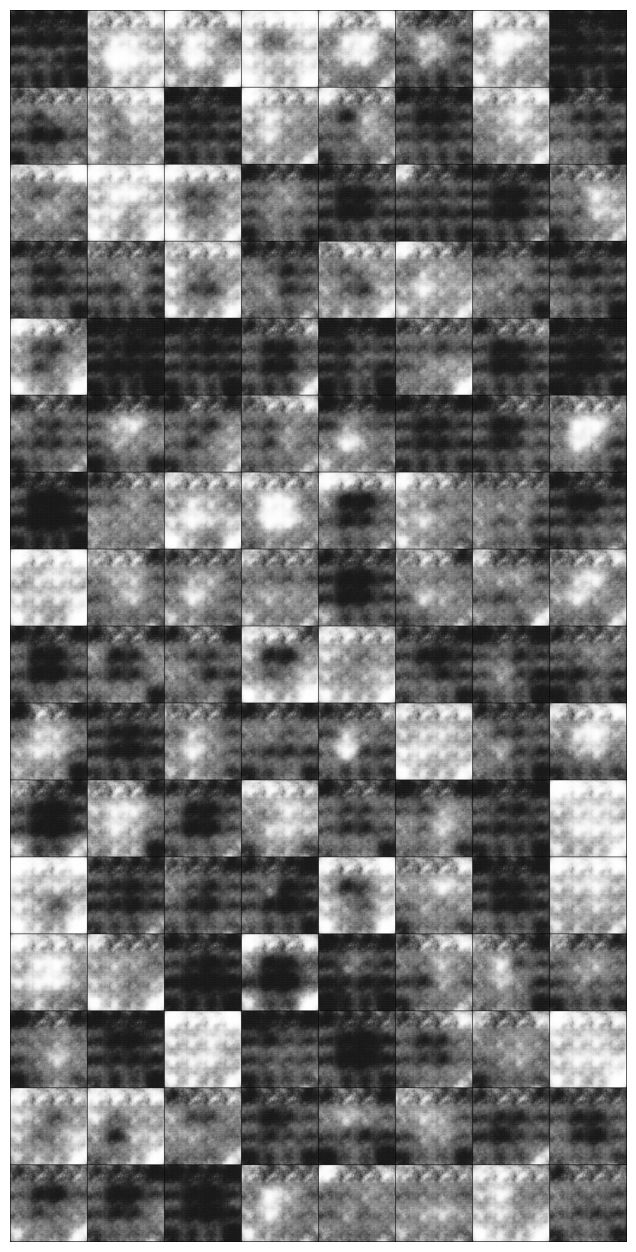

saved epoch 1
[2/5][0/660]	Loss_D: -0.1145	Loss_G: -0.4576	D(x): 0.5769	D(G(z)): 0.4625 / 0.4576
[2/5][50/660]	Loss_D: -0.1145	Loss_G: -0.4742	D(x): 0.5948	D(G(z)): 0.4803 / 0.4742
[2/5][100/660]	Loss_D: -0.1100	Loss_G: -0.4584	D(x): 0.5952	D(G(z)): 0.4853 / 0.4584
[2/5][150/660]	Loss_D: -0.1122	Loss_G: -0.4661	D(x): 0.5630	D(G(z)): 0.4508 / 0.4661
[2/5][200/660]	Loss_D: -0.1290	Loss_G: -0.4543	D(x): 0.5932	D(G(z)): 0.4642 / 0.4543
[2/5][250/660]	Loss_D: -0.1266	Loss_G: -0.4562	D(x): 0.5933	D(G(z)): 0.4667 / 0.4562
[2/5][300/660]	Loss_D: -0.1379	Loss_G: -0.4696	D(x): 0.6081	D(G(z)): 0.4702 / 0.4696
[2/5][350/660]	Loss_D: -0.1197	Loss_G: -0.4605	D(x): 0.5870	D(G(z)): 0.4673 / 0.4605
[2/5][400/660]	Loss_D: -0.0824	Loss_G: -0.4666	D(x): 0.5399	D(G(z)): 0.4575 / 0.4666
[2/5][450/660]	Loss_D: -0.0829	Loss_G: -0.4899	D(x): 0.5663	D(G(z)): 0.4835 / 0.4899
[2/5][500/660]	Loss_D: -0.0848	Loss_G: -0.5004	D(x): 0.5933	D(G(z)): 0.5085 / 0.5004
[2/5][550/660]	Loss_D: -0.0654	Loss_G: -0.4793	D(x): 0

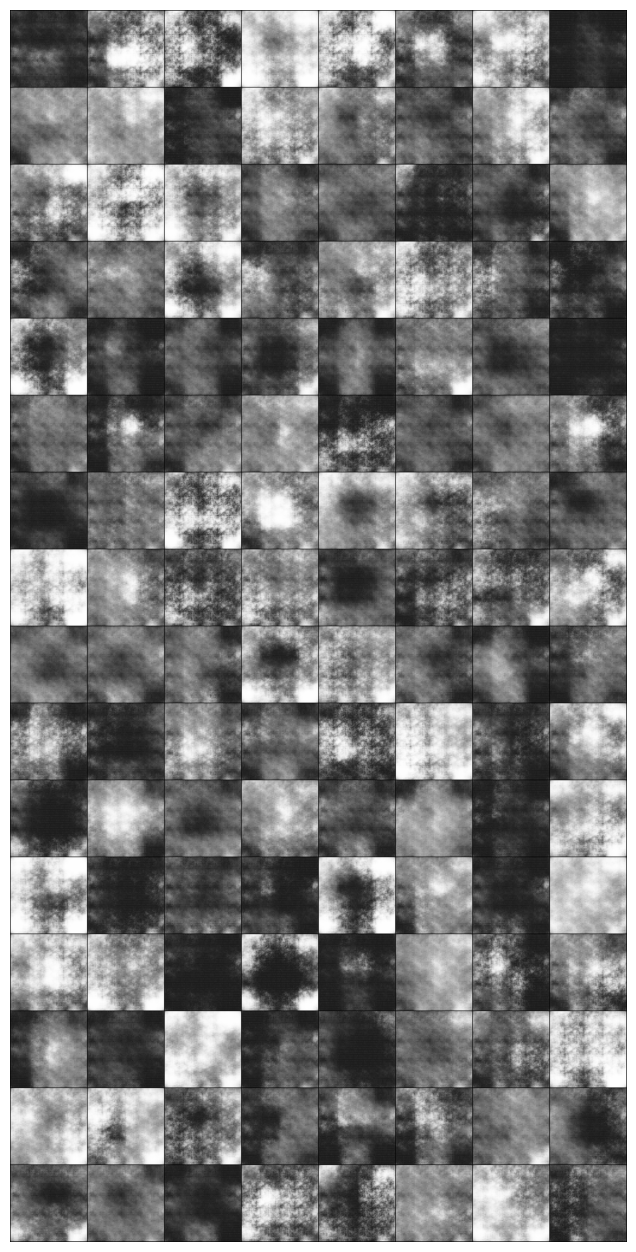

saved epoch 2
[3/5][0/660]	Loss_D: -0.0869	Loss_G: -0.5013	D(x): 0.5722	D(G(z)): 0.4854 / 0.5013
[3/5][50/660]	Loss_D: -0.0729	Loss_G: -0.4948	D(x): 0.5556	D(G(z)): 0.4827 / 0.4948
[3/5][100/660]	Loss_D: -0.0622	Loss_G: -0.5288	D(x): 0.6020	D(G(z)): 0.5397 / 0.5288
[3/5][150/660]	Loss_D: -0.0515	Loss_G: -0.4775	D(x): 0.5624	D(G(z)): 0.5109 / 0.4775
[3/5][200/660]	Loss_D: -0.0700	Loss_G: -0.4857	D(x): 0.5795	D(G(z)): 0.5096 / 0.4857
[3/5][250/660]	Loss_D: -0.0657	Loss_G: -0.4930	D(x): 0.5739	D(G(z)): 0.5082 / 0.4930
[3/5][300/660]	Loss_D: -0.0671	Loss_G: -0.5166	D(x): 0.5479	D(G(z)): 0.4809 / 0.5166
[3/5][350/660]	Loss_D: -0.0750	Loss_G: -0.5017	D(x): 0.5926	D(G(z)): 0.5177 / 0.5017
[3/5][400/660]	Loss_D: -0.0882	Loss_G: -0.4740	D(x): 0.5912	D(G(z)): 0.5030 / 0.4740
[3/5][450/660]	Loss_D: -0.0957	Loss_G: -0.4785	D(x): 0.5923	D(G(z)): 0.4966 / 0.4785
[3/5][500/660]	Loss_D: -0.0509	Loss_G: -0.4817	D(x): 0.5682	D(G(z)): 0.5174 / 0.4817
[3/5][550/660]	Loss_D: -0.0550	Loss_G: -0.5072	D(x): 0

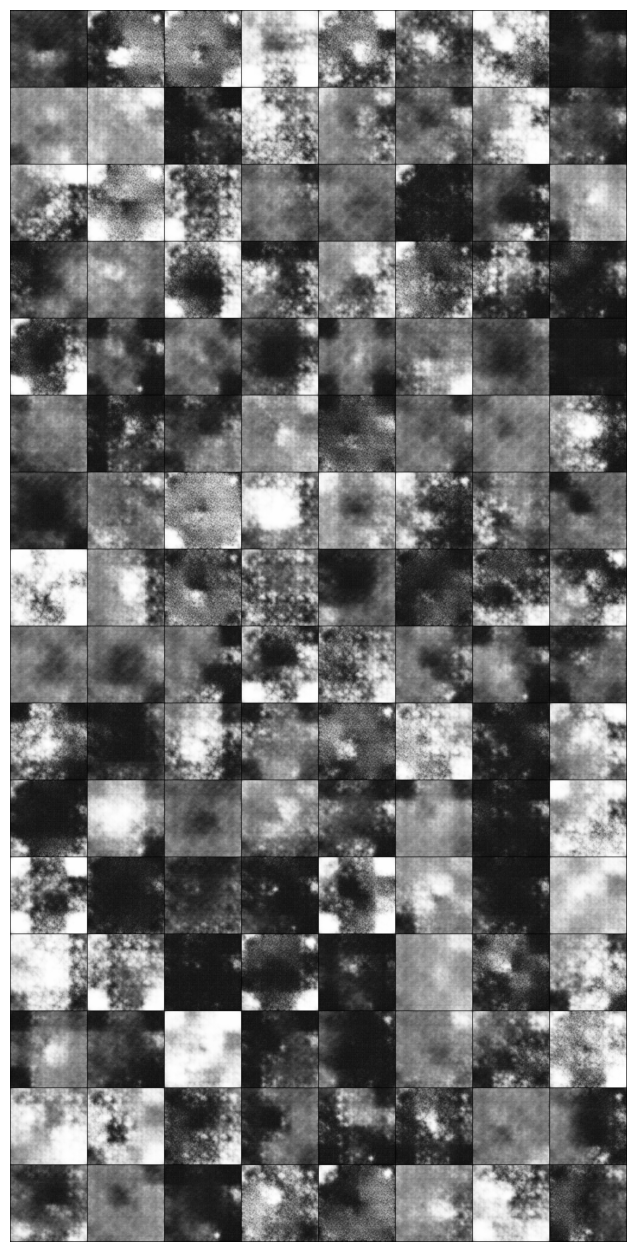

saved epoch 3
[4/5][0/660]	Loss_D: -0.0528	Loss_G: -0.5038	D(x): 0.5425	D(G(z)): 0.4897 / 0.5038
[4/5][50/660]	Loss_D: -0.0557	Loss_G: -0.5132	D(x): 0.5319	D(G(z)): 0.4761 / 0.5132
[4/5][100/660]	Loss_D: -0.0716	Loss_G: -0.5189	D(x): 0.5513	D(G(z)): 0.4797 / 0.5189
[4/5][150/660]	Loss_D: -0.0609	Loss_G: -0.5100	D(x): 0.5539	D(G(z)): 0.4930 / 0.5100
[4/5][200/660]	Loss_D: -0.0678	Loss_G: -0.4853	D(x): 0.5863	D(G(z)): 0.5185 / 0.4853
[4/5][250/660]	Loss_D: -0.0707	Loss_G: -0.5252	D(x): 0.5608	D(G(z)): 0.4902 / 0.5252
[4/5][300/660]	Loss_D: -0.0648	Loss_G: -0.4852	D(x): 0.5996	D(G(z)): 0.5348 / 0.4852
[4/5][350/660]	Loss_D: -0.0677	Loss_G: -0.4921	D(x): 0.5643	D(G(z)): 0.4966 / 0.4921
[4/5][400/660]	Loss_D: -0.0683	Loss_G: -0.4712	D(x): 0.5913	D(G(z)): 0.5230 / 0.4712
[4/5][450/660]	Loss_D: -0.0810	Loss_G: -0.5106	D(x): 0.5729	D(G(z)): 0.4919 / 0.5106
[4/5][500/660]	Loss_D: -0.0633	Loss_G: -0.5368	D(x): 0.5321	D(G(z)): 0.4688 / 0.5368
[4/5][550/660]	Loss_D: -0.0767	Loss_G: -0.4960	D(x): 0

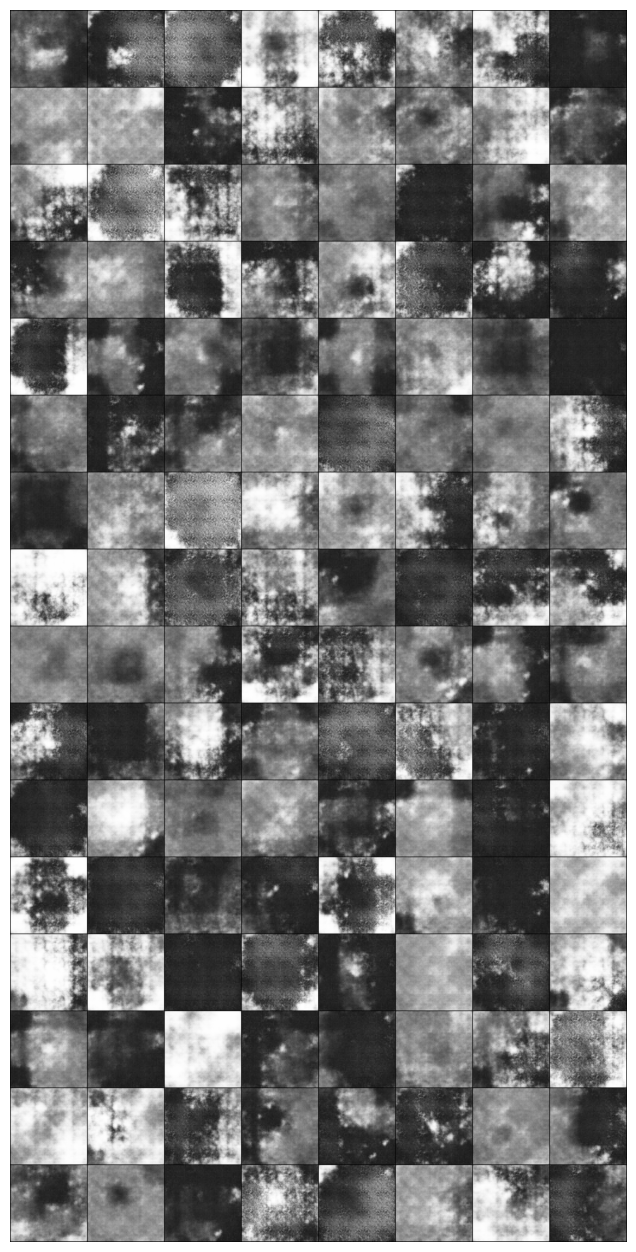

saved epoch 4
[5/5][0/660]	Loss_D: -0.0586	Loss_G: -0.5105	D(x): 0.5643	D(G(z)): 0.5056 / 0.5105
[5/5][50/660]	Loss_D: -0.0718	Loss_G: -0.4694	D(x): 0.5902	D(G(z)): 0.5183 / 0.4694
[5/5][100/660]	Loss_D: -0.0636	Loss_G: -0.5064	D(x): 0.5678	D(G(z)): 0.5042 / 0.5064
[5/5][150/660]	Loss_D: -0.0538	Loss_G: -0.4924	D(x): 0.5535	D(G(z)): 0.4997 / 0.4924
[5/5][200/660]	Loss_D: -0.0790	Loss_G: -0.4930	D(x): 0.5755	D(G(z)): 0.4966 / 0.4930
[5/5][250/660]	Loss_D: -0.0700	Loss_G: -0.4811	D(x): 0.5893	D(G(z)): 0.5193 / 0.4811
[5/5][300/660]	Loss_D: -0.0670	Loss_G: -0.5065	D(x): 0.5578	D(G(z)): 0.4908 / 0.5065
[5/5][350/660]	Loss_D: -0.0566	Loss_G: -0.5291	D(x): 0.5550	D(G(z)): 0.4985 / 0.5291
[5/5][400/660]	Loss_D: -0.0541	Loss_G: -0.4971	D(x): 0.5719	D(G(z)): 0.5177 / 0.4971
[5/5][450/660]	Loss_D: -0.0593	Loss_G: -0.5022	D(x): 0.5655	D(G(z)): 0.5062 / 0.5022
[5/5][500/660]	Loss_D: -0.0588	Loss_G: -0.6126	D(x): 0.5329	D(G(z)): 0.4741 / 0.6126
[5/5][550/660]	Loss_D: -0.0679	Loss_G: -0.5078	D(x): 0

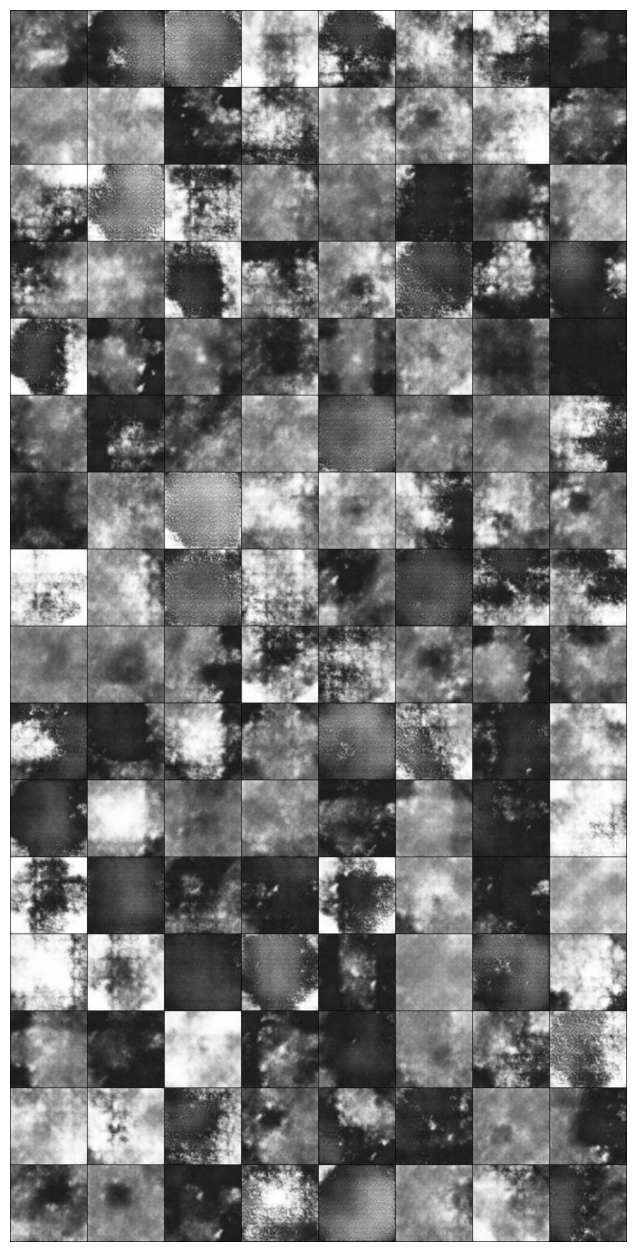

saved epoch 5


In [36]:
img_list = []
G_losses = []
D_losses = []
D_real_losses = []
D_fake_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(1,num_epochs+1):
    for i, data in enumerate(dataloader, 0):
        for _ in range (5):
            ##train with all reals
            netD.zero_grad()
            #setup batch
            real_cpu = data.to(device)
            b_size = real_cpu.size(0)
    #         label = torch.full((b_size,1), real_label, dtype=torch.float, device = device)

            #fwd pass thru D
            output = netD(real_cpu)
            errD_real = -torch.mean(output)
            D_x = output.mean().item()
            ##train with all fakes
            #gen batch of latent

            noise = torch.randn(b_size, 100,1,1, device = device)
            #generate fake batch by G
            fake = netG(noise)
            output = netD(fake.detach())
            D_G_z1 = output.mean().item()
            errD_fake = torch.mean(output)
            #compute errD as sum of fake and real
            errD = errD_fake + errD_real

            #update D
            errD.backward()
            optimizerD.step()
            
            with torch.no_grad():
                for name, param in netD.named_parameters():
                    if 'batch' not in name:
                        param.clamp_(-0.01,0.01)

        
        ############################
        # (2) Update G network
        ###########################
        
        netG.zero_grad()
#         label.fill_(real_label)# fake labels are real for generator cost
        noise = torch.randn(b_size, 100,1,1, device = device)
        fake = netG(noise)
        output = netD(fake)
        errG = -torch.mean(output)
#         print(errG)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i%50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_real_losses.append(errD_real.item())
        D_fake_losses.append(errD_fake.item())
        
    print(f"EPOCH_{epoch} OUTPUT")
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    grid_image = vutils.make_grid(torch.cat(img_list), padding = True, normalize = True)
    processed = np.transpose(grid_image.cpu().detach().numpy(), (1, 2, 0))
    wandb.log({f"generated-{epoch}" : wandb.Image(processed)})
    print(f"logged-{epoch}")
    fig = plt.figure(figsize=(16,16))
    plt.axis("off")
#     ims = [[ plt.imshow(np.transpose(i,(1,2,0)), cmap = 'gray')]for i in img_list]
    plt.imshow(np.transpose(grid_image, (1, 2, 0)), cmap='gray')
    plt.show()

    img_list = []
        
    
    PATH = f"/kaggle/working/checkpoints/{epoch}_GAN.pt"
    torch.save({

        'Gen_state_dict': netG.state_dict(),
        'Disc_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
    }, PATH)
    print(f"saved epoch {epoch}")
    iters += 1
PATH = f"/kaggle/working/checkpoints/last_GAN.pt"
torch.save({

    'Gen_state_dict': netG.state_dict(),
    'Disc_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
}, PATH)

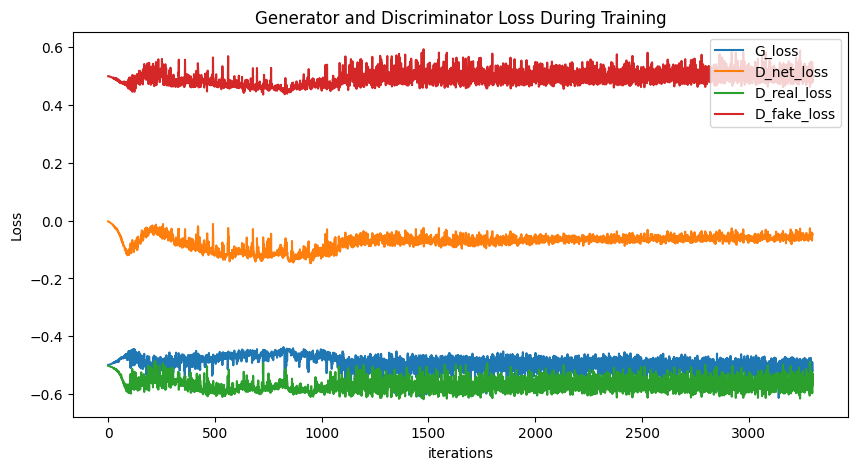

In [37]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G_loss")
plt.plot(D_losses,label="D_net_loss")
plt.plot(D_real_losses, label = "D_real_loss")
plt.plot(D_fake_losses, label = "D_fake_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Losses graph.png")
plt.show()

In [38]:
!zip -r checkpoints.zip /kaggle/working/checkpoints

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/5_GAN.pt (deflated 9%)
  adding: kaggle/working/checkpoints/1_GAN.pt (deflated 9%)
  adding: kaggle/working/checkpoints/3_GAN.pt (deflated 9%)
  adding: kaggle/working/checkpoints/last_GAN.pt (deflated 9%)
  adding: kaggle/working/checkpoints/2_GAN.pt (deflated 9%)
  adding: kaggle/working/checkpoints/4_GAN.pt (deflated 9%)


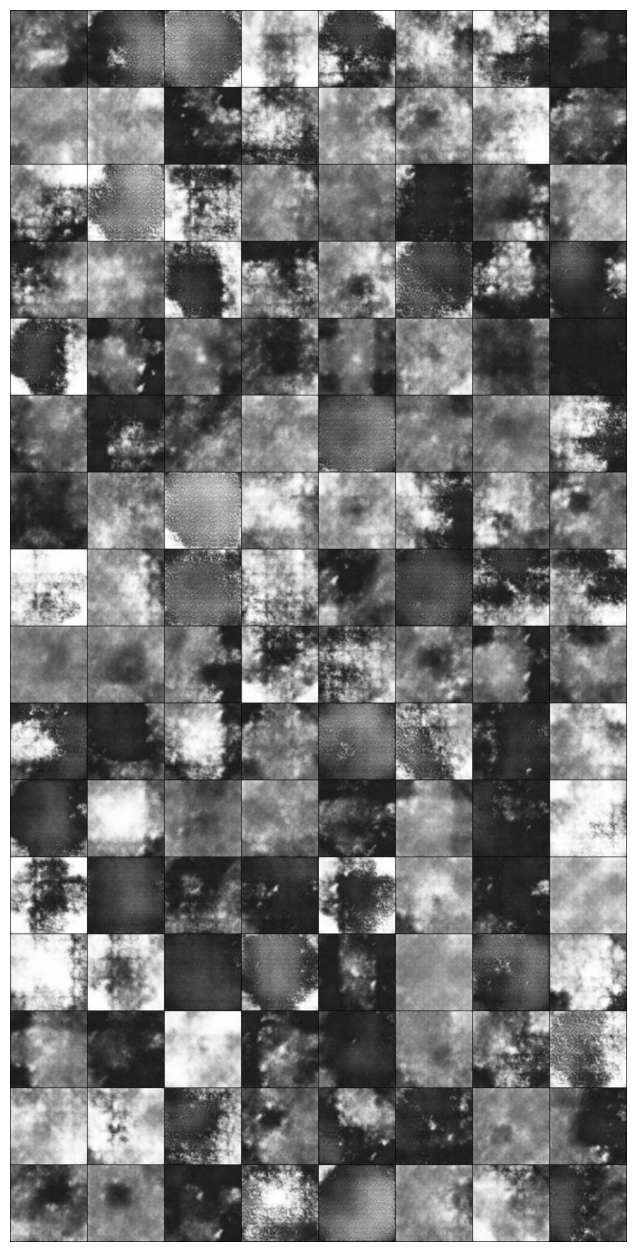

In [39]:
img_list = []
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
fig = plt.figure(figsize=(16,16))
plt.axis("off")
ims = [[ plt.imshow(np.transpose(i,(1,2,0)), cmap = 'gray')]for i in img_list]
plt.show()

In [40]:
!mkdir losses

In [41]:
import pickle
with open('/kaggle/working/losses/G_losses.pkl', 'wb') as f:
    pickle.dump(G_losses, f)

with open('/kaggle/working/losses/D_losses.pkl', 'wb') as f:
    pickle.dump(D_losses, f)

with open('/kaggle/working/losses/D_real_losses.pkl', 'wb') as f:
    pickle.dump(D_real_losses, f)
    
with open('/kaggle/working/losses/D_fake_losses.pkl', 'wb') as f:
    pickle.dump(D_fake_losses, f)

In [42]:
!zip -r losses.zip /kaggle/working/losses

  adding: kaggle/working/losses/ (stored 0%)
  adding: kaggle/working/losses/D_real_losses.pkl (deflated 58%)
  adding: kaggle/working/losses/G_losses.pkl (deflated 58%)
  adding: kaggle/working/losses/D_losses.pkl (deflated 57%)
  adding: kaggle/working/losses/D_fake_losses.pkl (deflated 58%)
